# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Select FRILL columns](#Select-FRILL-columns)
* [Throw out some *surprise* samples](#Throw-out-some-surprise-samples)
* [Throw out song samples](#Throw-out-song-samples)
* [Linear discriminant analysis of FRILL embeddings](#Linear-discriminant-analysis-of-FRILL-embeddings)
* [One-class linear discriminant analysis of FRILL embeddings](#One-class-linear-discriminant-analysis-of-FRILL-embeddings)
* [Local outlier factor of LDA components of FRILL embeddings](#Local-outlier-factor-of-LDA-components-of-FRILL-embeddings)
* [One-class SVM scores of the LDA components of the FRILL embeddings](One-class-SVM-scores-of-the-LDA-components-of-the-FRILL-embeddings)
* [SGDOneClassSVM scores of FRILL embeddings and resultant LDA components](#SGDOneClassSVM-scores-of-FRILL-embeddings-and-resultant-LDA-components)
* [Spherical coordinates](#Spherical-coordinates)
* [LDA components of spherical FRILL-based features](#LDA-components-of-spherical-FRILL-based-features)
* [One-class LDA components of spherical FRILL-based features](#One-class-LDA-components-of-spherical-FRILL-based-features)
* [Aggregate and scale](#Aggregate-and-scale)
* [Spot check](#Spot-check)
* [Discussion](#Discussion)

# Introduction

We are throwing out the song samples from training and re-running the simplified pipeline.

# Imports and configuration

In [2]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [3]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [4]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect
from joblib import dump
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# typing
from sklearn.base import BaseEstimator
from typing import Callable, List, Tuple

# feature engineering
from numpy import arctan2, sqrt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifierCV, SGDOneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib widget
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.9 s


In [5]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Path of the .txt file with the chosen FRILL features
SELECTED_FRILL_COLUMNS = "../23.0-mic-train_new_prototype_with_simplified_pipeline/selected_frill_columns.txt"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 90.4 ms


# Data loading

In [6]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "file",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "neg",
        "neu",
        "pos",
        "lang1",
        "length",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(filepath: str = "") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Loads the FRILL data anew by default"""
    data = (
        pd.read_feather(f"{filepath}.feather")
        if filepath
        else pd.concat(
            (
                pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather"),
                pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/nondev_FRILL.feather"),
            )
        )
    ).set_index("id")

    return data, load_labels().loc[data.index, :]


data, labels = load_data()
frill_columns = data.columns

assert all(data.index == labels.index)
_ = gc_collect()

time: 2 s


In [7]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 678.4 MB


,file,source,speaker_id,speaker_gender,emo,valence,neg,neu,pos,lang1,length
id,,,,,,,,,,,
0,00000+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav,aesdd,aesdd.1,f,ang,0,True,False,False,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            86752 non-null  object  
 1   source          86752 non-null  category
 2   speaker_id      86752 non-null  category
 3   speaker_gender  86752 non-null  category
 4   emo             86752 non-null  category
 5   valence         86752 non-null  int8    
 6   neg             86752 non-null  bool    
 7   neu             86752 non-null  bool    
 8   pos             86752 non-null  bool    
 9   lang1           86752 non-null  category
 10  length          86752 non-null  category
dtypes: bool(3), category(6), int8(1), object(1)
memory usage: 2.3+ MB
time: 141 ms


# Setup

In [8]:
# valence label codes
VALENCE = {"neg": 0, "neu": 1, "pos": 2}

# ternary to binary labels per class
RECODER = {
    "neg": lambda y: ((y - 1) // 2) * (-1),
    "neu": lambda y: y % 2,
    "pos": lambda y: y // 2,
}

_ = gc_collect()

time: 94.9 ms


In [9]:
def plot1d(data: pd.DataFrame, labels: pd.DataFrame, x: str) -> None:
    sns.displot(
        x=data[x],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
    )
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


_ = -gc_collect()

time: 104 ms


In [10]:
def plot2d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str) -> None:
    """Scatterplot of two variables"""
    _ = sns.histplot(
        x=data[x],
        y=data[y],
        cmap="RdPu",
        linewidth=0,
        alpha=0.2,
        legend=False,
        kde=True,
    )
    _ = sns.scatterplot(
        x=data[x],
        y=data[y],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
        s=10,
    )
    sns.despine(**dict.fromkeys("top right left bottom".split(), True))
    plt.show()


_ = gc_collect()

time: 105 ms


In [11]:
def plot3d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str, z: str) -> None:
    """Scatterplot of three variables"""
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        data[x],
        data[y],
        data[z],
        alpha=0.5,
        linewidth=0,
        cmap="viridis",
        c=labels.valence,
    )
    ax.grid(False)
    plt.show()


_ = gc_collect()

time: 120 ms


In [12]:
def checkpoint_features(df: pd.DataFrame, features: List[str]) -> None:
    """Save features to disk as a .feather dataframe"""
    df = df.loc[:, features]
    df.columns = df.columns.astype(str)
    try:
        df.to_feather(
            _ := f"{DATA_OUT_FOLDER}/{'_-_'.join(features) if len(features) > 1 else features[0]}.feather"
        )
    except ValueError:
        df.reset_index().to_feather(_)


_ = gc_collect()

time: 109 ms


In [13]:
def plot_importances(
    fitted_tree: BaseEstimator, fig_height: int = 50, title: str = ""
) -> None:
    """Plot top 100 feature importances"""
    data = pd.Series(
        fitted_tree.feature_importances_, index=fitted_tree.feature_names_in_
    ).sort_values(ascending=False)
    if len(data) >= 100:
        data = data.head(100)
    plt.figure(figsize=(10, fig_height))
    sns.barplot(
        x=data.values,
        y=data.index,
        seed=SEED,
        palette="colorblind",
        linewidth=0,
    )
    sns.despine(top=True, right=True)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 118 ms


In [14]:
bagged_gnb = lambda: BaggingClassifier(
    base_estimator=GaussianNB(),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
)
_ = gc_collect()

time: 112 ms


# Select FRILL columns based on previous pipeline

In [15]:
# for criterion in {"gini", "entropy"}:
#     for class_weight in {"balanced", "balanced_subsample", None}:
#         print(criterion, class_weight)
#         forest = RandomForestClassifier(
#             criterion=criterion,
#             max_depth=15,
#             min_samples_leaf=5,
#             max_leaf_nodes=2000,
#             bootstrap=True,
#             class_weight=class_weight,
#             oob_score=True,
#             n_jobs=-1,
#             random_state=SEED,
#         ).fit(data, labels.valence)
#         forest.oob_score_
#         print(f"mean importance:", np.mean(forest.feature_importances_))
#         plot_importances(forest)
_ = gc_collect()

time: 118 ms


In [16]:
with open(SELECTED_FRILL_COLUMNS, "r") as f:
    selected_frill_columns = [_.strip() for _ in f.readlines()]
data = data.loc[:, selected_frill_columns]

time: 104 ms


In [17]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.5280800442641091

time: 2min 6s


# Throw out song samples

The RAVDESS dataset contains vocal samples that were sung rather than spoken. The theoretical leap is questionable, so let's discard these from training.

In [18]:
with open("ravdess_songfiles.txt", "r") as f:
    lines = f.readlines()
labels = labels.loc[~labels.file.isin([f"{_.strip()}.wav" for _ in lines])]
data = data.loc[labels.index]
assert all(data.index == labels.index)
assert not data.isnull().values.any()

time: 330 ms


In [19]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.5296127828318171

time: 2min 3s


Improved!

# Throw out some *surprise* samples

In [20]:
# MAV surprise stays negative
# TESS is pleasant surprise
# keep EmoReact surprise valences
# keep MELD surprise valences
# keep vivae pleasant surprise

keep_surprise = {"EmoReact_V_1.0", "MAV", "MELD", "tess", "vivae"}
discard_index = (
    data.loc[~labels.source.isin(keep_surprise)].loc[labels.emo == "sur"].index
)
# data = data.loc[~data.index.isin(discard_index)]
# labels = labels.loc[data.index]
assert all(data.index == labels.index)
assert not data.isnull().values.any()
_ = gc_collect()

time: 518 ms


In [21]:
# bagged_gnb().fit(data, labels.valence).oob_score_
_ = gc_collect()
# output: 0.5270237253263036

time: 94.3 ms


Improved? not this time

In [22]:
del keep_surprise
del discard_index
_ = gc_collect()

time: 141 ms


# Linear discriminant analysis of FRILL embeddings

In [23]:
frill_data = deepcopy(data)

time: 78.2 ms


['./LDA1_-_LDA2.joblib']

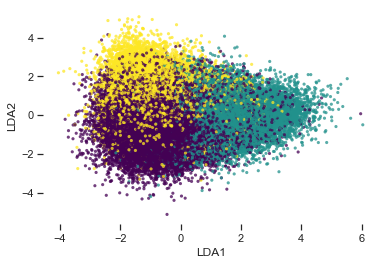

time: 22.5 s


In [24]:
lda = LinearDiscriminantAnalysis().fit(data, labels.valence)
dump(lda, f"{DATA_OUT_FOLDER}/LDA1_-_LDA2.joblib")
features = ["LDA1", "LDA2"]
data = pd.DataFrame(lda.transform(frill_data), columns=features)
data.index = labels.index
del lda
_ = gc_collect()
assert not data.isnull().values.any()
plot2d(data, labels, *features)
checkpoint_features(data, features)  # LDA1_-_LDA2.feather

In [25]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.6852111033356659

time: 863 ms


Improved!

# One-class linear discriminant analysis of FRILL embeddings

['./ocLDA_neg.joblib']

['./ocLDA_neu.joblib']

['./ocLDA_pos.joblib']

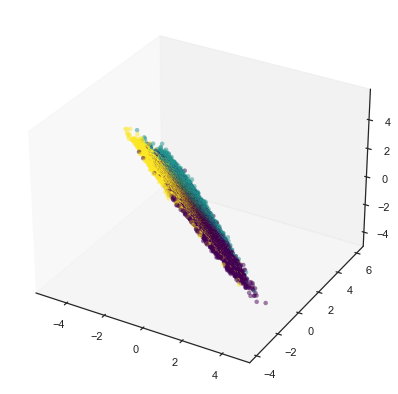

time: 1min 5s


In [26]:
for valence in VALENCE.keys():
    feature = f"ocLDA_{valence}"
    lda = LinearDiscriminantAnalysis().fit(frill_data, RECODER[valence](labels.valence))
    data[feature] = np.squeeze(lda.transform(frill_data))
    dump(lda, f"{DATA_OUT_FOLDER}/{feature}.joblib")
    del feature
    del lda
    _ = gc_collect()
features = ["ocLDA_neg", "ocLDA_neu", "ocLDA_pos"]
checkpoint_features(data, features)
plot3d(data, labels, *features)

assert not data.isnull().values.any()
_ = gc_collect()

# Local outlier factor of LDA components of FRILL embeddings

In [27]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/LDA1_-_LDA2")
assert len(data) == len(labels)

time: 94.1 ms


['./LDA-LOF_neg_30.joblib']

['./LDA-LOF_neu_30.joblib']

['./LDA-LOF_pos_30.joblib']

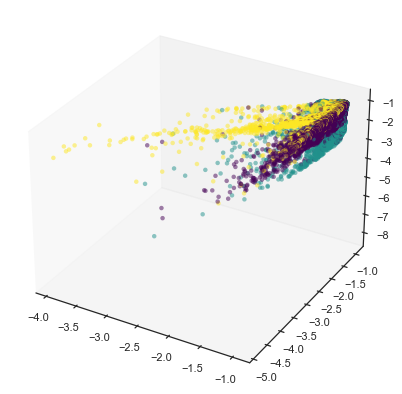

time: 2.6 s


In [28]:
n_neighbors = 30
for emo in ("neg", "neu", "pos"):
    valence = VALENCE[emo]
    key = f"LDA-LOF_{emo}_{n_neighbors}"
    data[key] = np.nan
    lof = LocalOutlierFactor(n_neighbors, novelty=True, n_jobs=-1).fit(
        data.loc[labels.valence == valence, ["LDA1", "LDA2"]].values
    )
    data.loc[labels.valence == valence, key] = lof.negative_outlier_factor_
    data.loc[labels.valence != valence, key] = lof.score_samples(
        data.loc[labels.valence != valence, ["LDA1", "LDA2"]].values
    )
    dump(lof, f"{DATA_OUT_FOLDER}/{key}.joblib")
    del valence
    del key
    del lof
    _ = gc_collect()
features = [
    f"LDA-LOF_neg_{n_neighbors}",
    f"LDA-LOF_neu_{n_neighbors}",
    f"LDA-LOF_pos_{n_neighbors}",
]
plot3d(data, labels, *features)
checkpoint_features(data, features)
del features
_ = gc_collect()

# One-class SVM scores of the LDA components of the FRILL embeddings

In [29]:
def extract_ocsvm_features(
    df: pd.DataFrame, labels: pd.DataFrame, model_base: Callable, descriptor: str
) -> pd.DataFrame:
    """Extract features using the given one-class SVM base"""
    prefix = f"ocSVM_{descriptor}"
    assert all(df.index == labels.index)

    # one-class scores of LDA components of FRILL embeddings
    print("extracting one-class scores of LDA components of FRILL embeddings...")
    for valence in VALENCE.keys():
        classifier = model_base().fit(
            df.loc[labels.valence == VALENCE[valence], ["LDA1", "LDA2"]]
        )
        feature = f"LDA-{prefix}_{valence}"
        df[feature] = classifier.score_samples(df.loc[:, ["LDA1", "LDA2"]])
        dump(classifier, f"{DATA_OUT_FOLDER}/{feature}.joblib")
        del classifier
        del feature
        _ = gc_collect()
    assert all(df.index == labels.index)
    features = [f"LDA-{prefix}_neg", f"LDA-{prefix}_neu", f"LDA-{prefix}_pos"]
    plot3d(df, labels, *features)
    checkpoint_features(df, features)

    return df


_ = gc_collect()

time: 112 ms


In [30]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/LDA1_-_LDA2")
assert len(data) == len(labels)
assert all(data.index == labels.index)

time: 94.2 ms


In [31]:
oc_svms = {
    "sgdlinear": lambda: SGDOneClassSVM(random_state=SEED),
    "rbf": lambda: OneClassSVM(kernel="rbf"),
    "sigmoid": lambda: OneClassSVM(kernel="sigmoid"),
    "poly5": lambda: OneClassSVM(kernel="poly", degree=5),
    "poly6": lambda: OneClassSVM(kernel="poly", degree=6),
}
_ = gc_collect()

time: 125 ms


  0%|          | 0/5 [00:00<?, ?it/s]

extracting one-class scores of LDA components of FRILL embeddings...


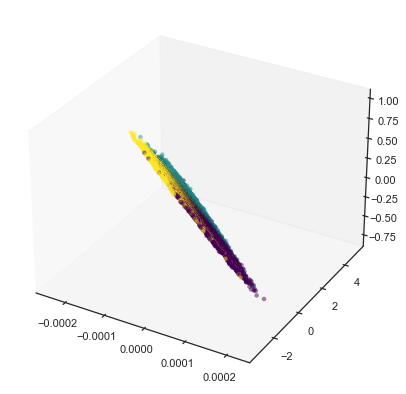

extracting one-class scores of LDA components of FRILL embeddings...


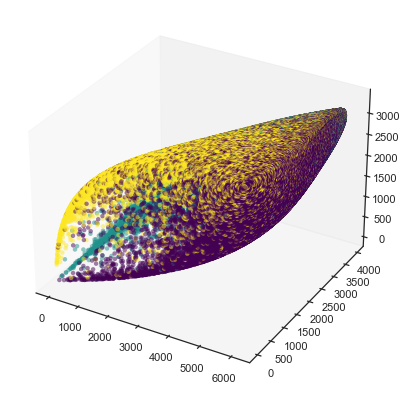

extracting one-class scores of LDA components of FRILL embeddings...


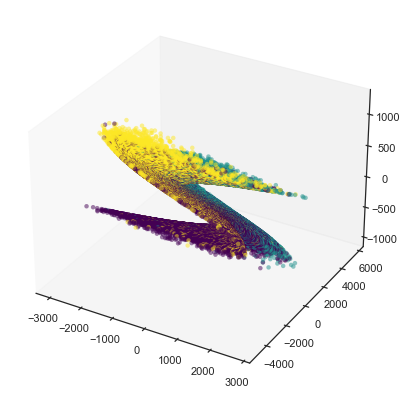

extracting one-class scores of LDA components of FRILL embeddings...


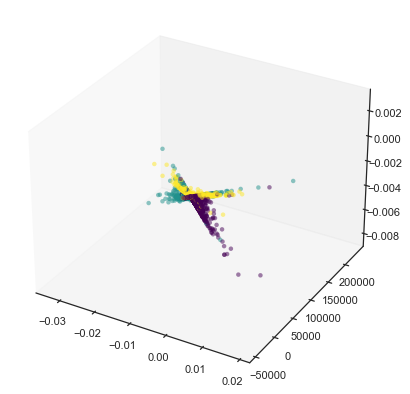

extracting one-class scores of LDA components of FRILL embeddings...


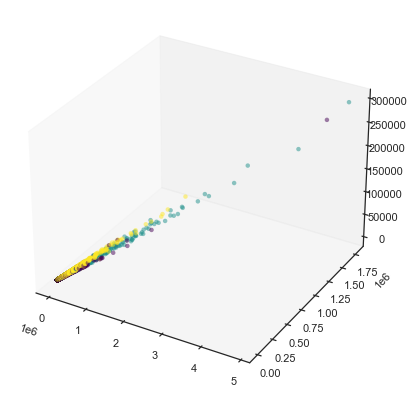

time: 1d 1h 7min 38s


In [32]:
for oc_svm, model_base in tqdm(oc_svms.items()):
    data = extract_ocsvm_features(data, labels, model_base, oc_svm)

# SGDOneClassSVM scores of FRILL embeddings and resultant LDA components

['./ocSVM_sgdlinear_neg.joblib']

['./ocSVM_sgdlinear_neu.joblib']

['./ocSVM_sgdlinear_pos.joblib']

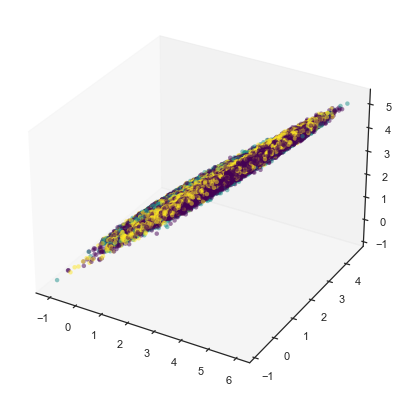

time: 4.96 s


In [41]:
prefix = f"ocSVM_sgdlinear"
df = {}
assert len(frill_data.columns) == 1024
for valence in VALENCE.keys():
    classifier = SGDOneClassSVM(random_state=SEED).fit(
        frill_data.loc[labels.valence == VALENCE[valence], :]
    )
    feature = f"{prefix}_{valence}"
    df[feature] = classifier.score_samples(frill_data)
    dump(classifier, f"{DATA_OUT_FOLDER}/{feature}.joblib")
    del classifier
    _ = gc_collect()
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
df = pd.DataFrame(df, columns=features)
df.index = labels.index
plot3d(df, labels, *features)
checkpoint_features(df, features)

In [42]:
prefix = "ocSVM_sgdlinear"
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]

time: 1.03 ms


['./ocSVM_sgdlinear_LDA1_-_ocSVM_sgdlinear_LDA2.joblib']

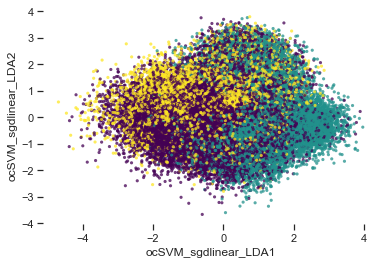

time: 1.09 s


In [43]:
lda = LinearDiscriminantAnalysis().fit(df.loc[:, features], labels.valence)
dump(lda, f"{DATA_OUT_FOLDER}/ocSVM_sgdlinear_LDA1_-_ocSVM_sgdlinear_LDA2.joblib")
features_ = ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"]
data = pd.DataFrame(lda.transform(df.loc[:, features]), columns=features_)
data.index = labels.index
del lda
_ = gc_collect()
assert not data.isnull().values.any()
plot2d(data, labels, *features_)
checkpoint_features(data, features_)

# Spherical coordinates

We are dropping the rho coordinates

In [44]:
features_ = [
    ["LDA1", "LDA2"],
    ["ocLDA_neg", "ocLDA_neu", "ocLDA_pos"],
    ["ocSVM_sgdlinear_LDA1", "ocSVM_sgdlinear_LDA2"],
    ["ocSVM_sgdlinear_neg", "ocSVM_sgdlinear_neu", "ocSVM_sgdlinear_pos"],
    ["LDA-LOF_neg_30", "LDA-LOF_neu_30", "LDA-LOF_pos_30"],
]

for descriptor in oc_svms.keys():
    features_.extend(
        [
            [
                f"LDA-ocSVM_{descriptor}_neg",
                f"LDA-ocSVM_{descriptor}_neu",
                f"LDA-ocSVM_{descriptor}_pos",
            ],
        ]
    )

_ = gc_collect()

time: 113 ms


LDA1_-_LDA2.feather
85740 ['LDA1', 'LDA2']


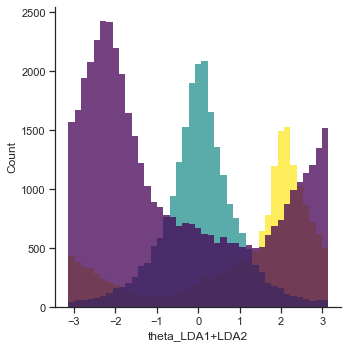

ocLDA_neg_-_ocLDA_neu_-_ocLDA_pos.feather
85740 ['ocLDA_neg', 'ocLDA_neu', 'ocLDA_pos']


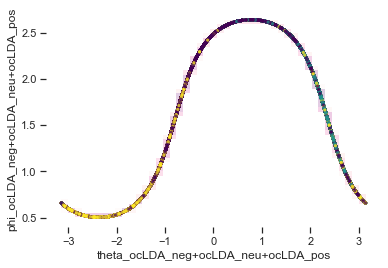

ocSVM_sgdlinear_LDA1_-_ocSVM_sgdlinear_LDA2.feather
85740 ['ocSVM_sgdlinear_LDA1', 'ocSVM_sgdlinear_LDA2']


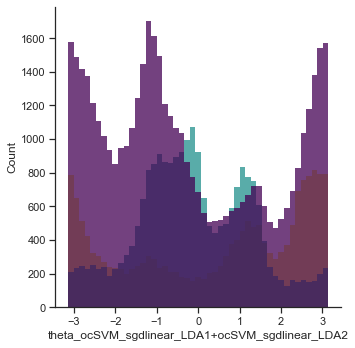

ocSVM_sgdlinear_neg_-_ocSVM_sgdlinear_neu_-_ocSVM_sgdlinear_pos.feather
85740 ['ocSVM_sgdlinear_neg', 'ocSVM_sgdlinear_neu', 'ocSVM_sgdlinear_pos']


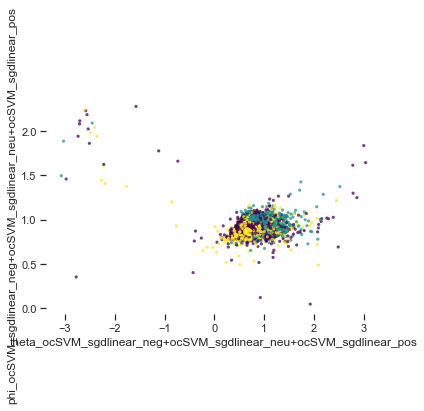

LDA-LOF_neg_30_-_LDA-LOF_neu_30_-_LDA-LOF_pos_30.feather
85740 ['LDA-LOF_neg_30', 'LDA-LOF_neu_30', 'LDA-LOF_pos_30']


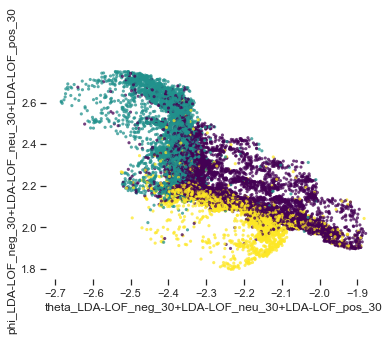

LDA-ocSVM_sgdlinear_neg_-_LDA-ocSVM_sgdlinear_neu_-_LDA-ocSVM_sgdlinear_pos.feather
85740 ['LDA-ocSVM_sgdlinear_neg', 'LDA-ocSVM_sgdlinear_neu', 'LDA-ocSVM_sgdlinear_pos']


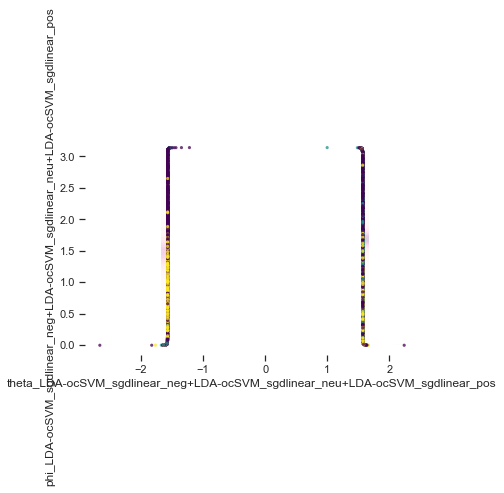

LDA-ocSVM_rbf_neg_-_LDA-ocSVM_rbf_neu_-_LDA-ocSVM_rbf_pos.feather
85740 ['LDA-ocSVM_rbf_neg', 'LDA-ocSVM_rbf_neu', 'LDA-ocSVM_rbf_pos']


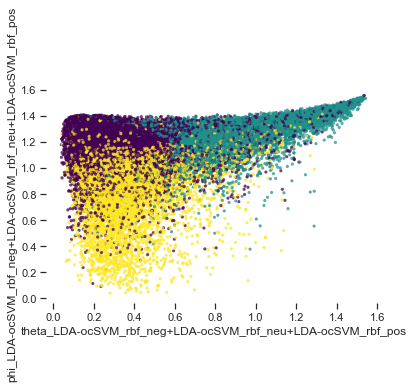

LDA-ocSVM_sigmoid_neg_-_LDA-ocSVM_sigmoid_neu_-_LDA-ocSVM_sigmoid_pos.feather
85740 ['LDA-ocSVM_sigmoid_neg', 'LDA-ocSVM_sigmoid_neu', 'LDA-ocSVM_sigmoid_pos']


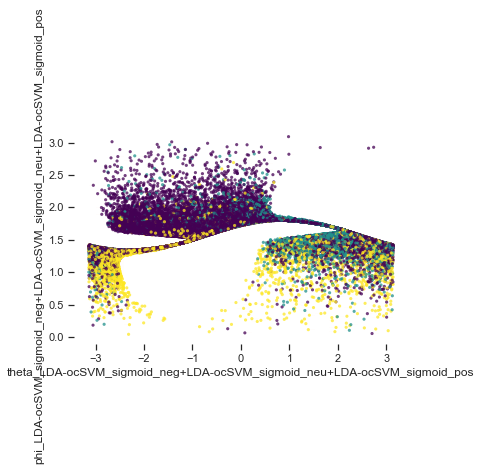

LDA-ocSVM_poly5_neg_-_LDA-ocSVM_poly5_neu_-_LDA-ocSVM_poly5_pos.feather
85740 ['LDA-ocSVM_poly5_neg', 'LDA-ocSVM_poly5_neu', 'LDA-ocSVM_poly5_pos']


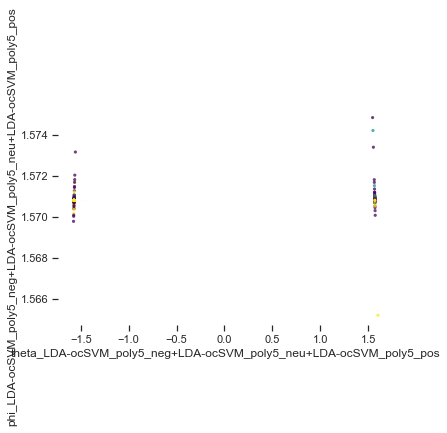

LDA-ocSVM_poly6_neg_-_LDA-ocSVM_poly6_neu_-_LDA-ocSVM_poly6_pos.feather
85740 ['LDA-ocSVM_poly6_neg', 'LDA-ocSVM_poly6_neu', 'LDA-ocSVM_poly6_pos']


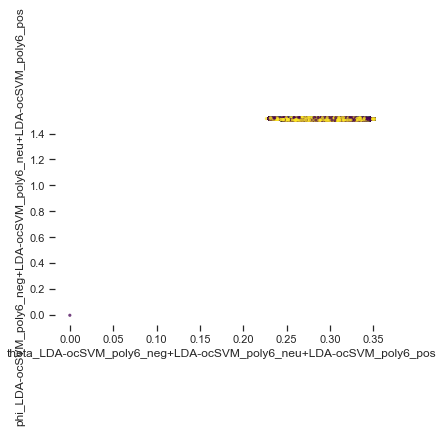

time: 37 s


In [45]:
# rho coordinate omitted
sphericals = {}
for features in features_:
    combo = "+".join(features)
    df = pd.read_feather(f"{DATA_OUT_FOLDER}/{'_-_'.join(features)}.feather")
    print(f"{'_-_'.join(features)}.feather")
    df = df.set_index("id")
    labels = load_labels().loc[df.index]
    print(len(labels), features)
    assert not df.isnull().values.any()
    assert all(df.index == labels.index)
    x, y = df[features[0]], df[features[1]]
    theta, phi = f"theta_{combo}", f"phi_{combo}"
    sphericals[theta] = arctan2(y, x)
    # convert to polar
    if len(features) == 3:
        sphericals[phi] = arctan2(sqrt(x ** 2 + y ** 2), df[features[2]])
        plot2d(
            df := pd.DataFrame({theta: sphericals[theta], phi: sphericals[phi]}),
            labels,
            theta,
            phi,
        )
        assert not df.isnull().values.any()
    else:
        plot1d(df := pd.DataFrame({theta: sphericals[theta]}), labels, theta)
        assert not df.isnull().values.any()
    del df
    del x
    del y
    del combo
    _ = gc_collect()

df = pd.DataFrame(sphericals)
df.columns = df.columns.astype(str)
assert not df.isnull().values.any()
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/spherical_features.feather")
del sphericals
_ = gc_collect()

# LDA components of spherical FRILL-based features

In [46]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/spherical_features")
assert all(data.index == labels.index)
assert not data.isnull().values.any()

time: 97.8 ms


['./spherical-LDA1_-_spherical-LDA2.joblib']

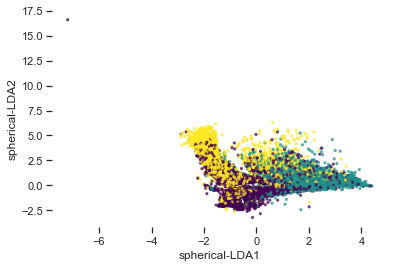

time: 1.36 s


In [47]:
new_feats = []
lda = LinearDiscriminantAnalysis().fit(data, labels.valence)
dump(lda, f"{DATA_OUT_FOLDER}/spherical-LDA1_-_spherical-LDA2.joblib")
features = ["spherical-LDA1", "spherical-LDA2"]
df = pd.DataFrame(lda.transform(data), columns=features)
df.index = data.index
del data
del lda
_ = gc_collect()
plot2d(df, labels, *features)
checkpoint_features(df, features)
new_feats.append(features)

# One-class LDA components of spherical FRILL-based features

In [48]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/spherical_features")

time: 81 ms


['./spherical-ocLDA_neg.joblib']

['./spherical-ocLDA_neu.joblib']

['./spherical-ocLDA_pos.joblib']

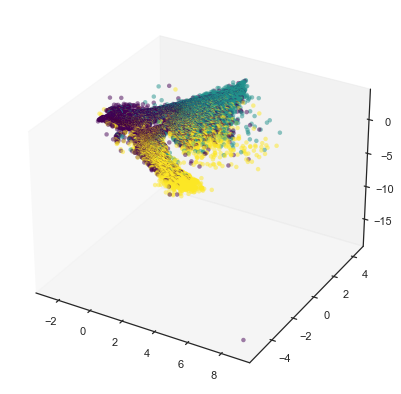

time: 2.14 s


In [49]:
df = {}
features = []
for valence in VALENCE:
    features.append(feature := f"spherical-ocLDA_{valence}")
    lda = LinearDiscriminantAnalysis().fit(data, RECODER[valence](labels.valence))
    dump(lda, f"{DATA_OUT_FOLDER}/{feature}.joblib")
    df[feature] = np.squeeze(lda.transform(data))
    del feature
    del lda
    _ = gc_collect()
df = pd.DataFrame(df, columns=features)
df.index = data.index
plot3d(df, labels, *features)
checkpoint_features(df, features)
del df
new_feats.append(features)
_ = gc_collect()

# Aggregate and scale

In [50]:
features_.extend(new_feats)
features_
_ = gc_collect()

[['LDA1', 'LDA2'],
 ['ocLDA_neg', 'ocLDA_neu', 'ocLDA_pos'],
 ['ocSVM_sgdlinear_LDA1', 'ocSVM_sgdlinear_LDA2'],
 ['ocSVM_sgdlinear_neg', 'ocSVM_sgdlinear_neu', 'ocSVM_sgdlinear_pos'],
 ['LDA-LOF_neg_30', 'LDA-LOF_neu_30', 'LDA-LOF_pos_30'],
 ['LDA-ocSVM_sgdlinear_neg',
  'LDA-ocSVM_sgdlinear_neu',
  'LDA-ocSVM_sgdlinear_pos'],
 ['LDA-ocSVM_rbf_neg', 'LDA-ocSVM_rbf_neu', 'LDA-ocSVM_rbf_pos'],
 ['LDA-ocSVM_sigmoid_neg', 'LDA-ocSVM_sigmoid_neu', 'LDA-ocSVM_sigmoid_pos'],
 ['LDA-ocSVM_poly5_neg', 'LDA-ocSVM_poly5_neu', 'LDA-ocSVM_poly5_pos'],
 ['LDA-ocSVM_poly6_neg', 'LDA-ocSVM_poly6_neu', 'LDA-ocSVM_poly6_pos'],
 ['spherical-LDA1', 'spherical-LDA2'],
 ['spherical-ocLDA_neg', 'spherical-ocLDA_neu', 'spherical-ocLDA_pos']]

time: 114 ms


In [51]:
data = pd.concat(
    [
        pd.read_feather(f"{DATA_OUT_FOLDER}/{fname}.feather").set_index("id")
        for fname in ["_-_".join(features) for features in features_]
    ],
    axis="columns",
)
labels = load_labels().loc[data.index]
assert not data.isnull().values.any()
assert len(data) < 86000

time: 181 ms


In [52]:
data = pd.concat(
    [
        data,
        pd.read_feather(f"{DATA_OUT_FOLDER}/spherical_features.feather").set_index(
            "id"
        ),
    ],
    axis="columns",
)

time: 37 ms


In [53]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.6635409377186844

time: 9.92 s


In [54]:
bagged_gnb().fit(RobustScaler().fit_transform(data), labels.valence).oob_score_

0.6668299510146956

time: 7.47 s


In [55]:
bagged_gnb().fit(
    RobustScaler(unit_variance=True).fit_transform(data), labels.valence
).oob_score_

0.6668299510146956

time: 7.27 s


In [57]:
BaggingClassifier(
    base_estimator=RidgeClassifierCV(scoring="balanced_accuracy"),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(RobustScaler().fit_transform(data), labels.valence).oob_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   16.3s remaining:   49.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.1s finished


0.6882202006064847

time: 20.6 s


In [58]:
BaggingClassifier(
    base_estimator=RidgeClassifierCV(scoring="balanced_accuracy"),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(RobustScaler(unit_variance=True).fit_transform(data), labels.valence).oob_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   14.2s remaining:   42.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.4s finished


0.6882901796127828

time: 19.6 s


In [59]:
dump(
    RobustScaler(unit_variance=True).fit(data),
    f"{DATA_OUT_FOLDER}/robust_scaler.joblib",
)

['./robust_scaler.joblib']

time: 137 ms


In [60]:
cols = data.columns
data = pd.DataFrame(RobustScaler().fit_transform(data), columns=cols)
data.columns = data.columns.astype(str)
assert len(labels.index) < 86000
data.index = labels.index
data.reset_index().to_feather(
    f"{DATA_OUT_FOLDER}/scaled_features_ready_for_selection.feather"
)
del cols
_ = gc_collect()

time: 350 ms


# Spot check

In [61]:
data = pd.read_feather(
    f"{DATA_OUT_FOLDER}/scaled_features_ready_for_selection.feather"
).set_index("id")
labels = load_labels().loc[data.index]
assert len(data) == len(labels)
assert not data.isnull().values.any()
assert all(data.index == labels.index)

time: 141 ms


In [62]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.6668299510146956

time: 7.1 s


In [63]:
selected_features = {
    "three_sphericals": [
        "spherical-ocLDA_neg",
        "spherical-ocLDA_neu",
        "spherical-ocLDA_pos",
    ],
    "two_sphericals": ["spherical-LDA1", "spherical-LDA2"],
}
selected_features["five_sphericals"] = (
    selected_features["three_sphericals"] + selected_features["two_sphericals"]
)
for feature_set, features in selected_features.items():
    df = data.loc[:, features]
    print(feature_set, bagged_gnb().fit(df, labels.valence).oob_score_)

three_sphericals 0.6716235129461162
two_sphericals 0.6755190109633776
five_sphericals 0.6616748308840681
time: 3.39 s


In [64]:
assert len(data) < 86000
df.index
labels = load_labels().loc[df.index, :]
labels.index
labels.columns = labels.columns.astype(str)
labels.info()
labels.reset_index().to_feather(f"{DATA_OUT_FOLDER}/simplified_labels.feather")

UInt64Index([    0,     2,     4,     6,     8,    10,    12,    14,    16,
                18,
             ...
             87354, 87355, 87356, 87357, 87358, 87359, 87360, 87361, 87362,
             87363],
            dtype='uint64', name='id', length=85740)

UInt64Index([    0,     2,     4,     6,     8,    10,    12,    14,    16,
                18,
             ...
             87354, 87355, 87356, 87357, 87358, 87359, 87360, 87361, 87362,
             87363],
            dtype='uint64', name='id', length=85740)

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            85740 non-null  object  
 1   source          85740 non-null  category
 2   speaker_id      85740 non-null  category
 3   speaker_gender  85740 non-null  category
 4   emo             85740 non-null  category
 5   valence         85740 non-null  int8    
 6   neg             85740 non-null  bool    
 7   neu             85740 non-null  bool    
 8   pos             85740 non-null  bool    
 9   lang1           85740 non-null  category
 10  length          85740 non-null  category
dtypes: bool(3), category(6), int8(1), object(1)
memory usage: 2.3+ MB
time: 143 ms


# Discussion

Looks like the simplified feature set isn't so bad.

In [65]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 92319.60339450836 s
time: 115 ms


[^top](#Contents)